In [278]:
# Things to finish before reaching out to GroteRoutepaden:
# 1: ColorLine -> DONE
# 2: Make plots of highway/surface/tracktype
# 3: Determine paved status rules
# 4: Fix double pathing
# 5: Make plots: percentage paved vs. unpaved, length of individual paved/unpaved sections
# 6: Brainstorm about other outputs that may be useful: closest town, topography type (forest, plains, etc.), elevation profile

In [279]:
# Preamble
from IPython.display import IFrame
from itertools import groupby 
from csv import writer
import networkx as nx
import pandas as pd
import numpy as np
import osmnx as ox
import warnings
import folium
import branca.colormap as cm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [280]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [281]:
# --- Load and process the GPX track
trail = 'gr131'
# trail = 'gr16'
points_per_batch = 100
filename_in = 'data/' + trail + '.csv'
hike = pd.read_csv(filename_in)
coords = hike[['latitude','longitude']].values.tolist()
n_batch = int(np.ceil(hike.shape[0]/points_per_batch))

In [282]:
filename = 'data/' + trail + '_0to' + str(points_per_batch) + '.csv'
df = pd.read_csv(filename,dtype={'surface': str})
# Loading data and merging
for b in range(1,n_batch): # b is the batch counter
    n1 = b*points_per_batch # First point
    n2 = min(n1 + points_per_batch, len(hike)) # Last point
    filename = 'data/' + trail + '_' + str(n1) + 'to' + str(n2) + '.csv'
    df_new = pd.read_csv(filename,dtype={'surface': str})
    df = pd.concat([df,df_new],ignore_index=True)

## Defining paved status

In [283]:
df['paved'] = df['highway'].isin(['track','path'])

## Plotting the route

In [284]:
# Set up ColorLine data
x = df['x0'].values.tolist()
y = df['y0'].values.tolist()
x.extend(df.tail(1)['x1'])
y.extend(df.tail(1)['y1'])
colors = df['paved'].values.tolist()
colors[colors==True] = 1
colors[colors==False] = 0
xy0 = list(zip(x,y))
xy = [[coord[0],coord[1]] for coord in xy0]
colormap = cm.LinearColormap(colors=['black','#239621'],vmin=0.25,vmax=0.75,index=[0.25,0.75])

In [285]:
# Map setup
mid = int(len(coords)/2)
chart = folium.Map(location=coords[mid], zoom_start=12, tiles="OpenStreetMap") 
   
# Draw matched route segments
newline = folium.ColorLine(positions=xy, colors=colors, colormap=colormap, weight=3)
newline.add_to(chart)

# Render the map
filepath = "data/chart.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

## Statistics

In [313]:
# Paved and unpaved sections
df['paved'] = df['highway'].isin(['track','path'])
tot_unpaved = df[df['paved']]['d_cart'].sum()
tot_paved = df[~df['paved']]['d_cart'].sum()
tot = tot_unpaved + tot_paved
print(f'Percentage paved: {round(tot_paved/tot,10)}')
print(f'Percentage unpaved: {round(tot_unpaved/tot,10)}')

Percentage paved: 0.7684635062
Percentage unpaved: 0.2315364938


In [309]:
group_paving = df.groupby((df['paved'].shift() != df['paved']).cumsum())
paved_cumul = group_paving['d_cart'].sum().to_frame()
paved_cumul['paved'] = True
for k, v in group_paving:
    i0 = v['paved'].index[0]
    this_paved = v['paved'].loc[i0]
    paved_cumul['paved'].loc[k] = this_paved
paved_cumul['d_cumul'] = paved_cumul['d_cart'].cumsum()

/var/folders/zh/x06gqp657rl9h1shq_pn7gjh0000gn/T/ipykernel_6340/2794515534.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paved_cumul['paved'].loc[k] = this_paved


In [310]:
paved_cumul

,d_cart,paved,d_cumul
paved,,,
1,3579.724224,False,3579.724224
2,638.01337,True,4217.737594
3,6830.634252,False,11048.371846
4,1192.793794,True,12241.16564
5,671.371433,False,12912.537073
...,...,...,...
80,2219.775416,True,139346.697054
81,657.21282,False,140003.909874
82,1266.985706,True,141270.89558


In [311]:
sections_paved = paved_cumul[paved_cumul['paved']]
sectionsun_paved = paved_cumul[~paved_cumul['paved']]

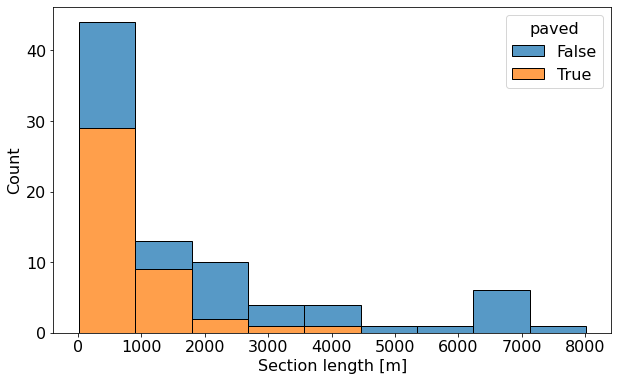

In [312]:
# sns.displot(kind='hist',data=paved_cumul,x='d_cart',hue='paved',col='paved')
plt.figure(figsize=(10,6))
plt.rc('font', size=16)
sns.histplot(data=paved_cumul,x='d_cart',hue='paved',multiple='stack')
plt.xlabel('Section length [m]')
plt.show()